<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/Plant_disease_classification/blob/master/%ED%8C%80%ED%94%8C_Resnet(%EC%A0%84%EC%B2%B4%EB%A0%88%EC%9D%B4%EC%96%B4%ED%95%99%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50
from keras import optimizers
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json

In [35]:
from google.colab import drive
drive.mount('/content/gdrive')
dst_path = '/content/gdrive/My Drive/dataset_split_aug'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
import os
os.chdir('/content/gdrive/My Drive/dataset_split_aug')

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'train')
validation_dir = os.path.join(dst_path, 'validation')
test_dir = os.path.join(dst_path, 'test')

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(64,64),
                                                    batch_size=64,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(64,64),
                                                        batch_size=64,
                                                        class_mode='categorical')

Found 30748 images belonging to 33 classes.
Found 7989 images belonging to 33 classes.


In [38]:
SIZE=64
N_ch=3

In [43]:
input_tensor = Input(shape=(SIZE, SIZE, N_ch))
conv_base = ResNet50(include_top=False, weights='imagenet',input_tensor=input_tensor,pooling='max')
for layer in conv_base.layers[90:]:
    layer.trainable = True

In [14]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [44]:
x = conv_base.output
output = layers.Dense(33, activation='softmax')(x)
model = Model(input_tensor, output)

#optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss='categorical_crossentropy',optimizer=optimizers.adam(),metrics=['accuracy'])

In [24]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [45]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
MODEL_SAVE_FOLDER_PATH='/content/gdrive/My Drive/'
model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpoint= ModelCheckpoint(filepath=model_path,monitor='val_acc',verbose=1, save_best_only=True)
earlystop=EarlyStopping(patience=7)
my_callbacks = [earlystop,checkpoint, annealer]

In [46]:
# Fits the model on batches with real-time data augmentation
resnet = model.fit_generator(train_generator, steps_per_epoch=550,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
550/550 [==============================] - 10419s 19s/step - loss: 1.7527 - accuracy: 0.6368 - val_loss: 11.0265 - val_accuracy: 0.0426
Epoch 2/50
  1/550 [..............................] - ETA: 1:14 - loss: 0.3535 - accuracy: 0.8750

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


550/550 [==============================] - 817s 1s/step - loss: 0.4843 - accuracy: 0.8520 - val_loss: 2.5836 - val_accuracy: 0.4146
Epoch 3/50
550/550 [==============================] - 166s 302ms/step - loss: 0.3800 - accuracy: 0.8853 - val_loss: 1.1842 - val_accuracy: 0.7318
Epoch 4/50
550/550 [==============================] - 170s 309ms/step - loss: 0.3624 - accuracy: 0.8892 - val_loss: 5.6005 - val_accuracy: 0.3202
Epoch 5/50
550/550 [==============================] - 167s 303ms/step - loss: 1.5628 - accuracy: 0.7238 - val_loss: 24.8933 - val_accuracy: 0.3654
Epoch 6/50
550/550 [==============================] - 170s 309ms/step - loss: 0.6884 - accuracy: 0.8177 - val_loss: 1.5264 - val_accuracy: 0.6373
Epoch 7/50
550/550 [==============================] - 168s 306ms/step - loss: 0.3888 - accuracy: 0.8796 - val_loss: 0.2130 - val_accuracy: 0.9012
Epoch 8/50
550/550 [==============================] - 168s 305ms/step - loss: 0.3642 - accuracy: 0.8911 - val_loss: 0.8532 - val_accuracy

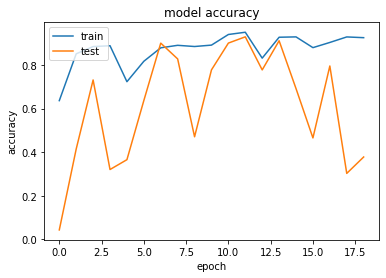

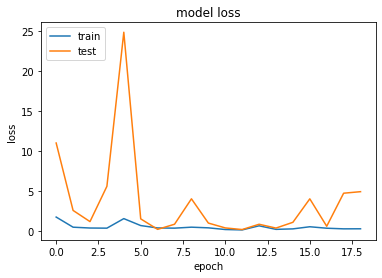

In [48]:
# accuracy plot 
plt.plot(resnet.history['accuracy'])
plt.plot(resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(resnet.history['loss'])
plt.plot(resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

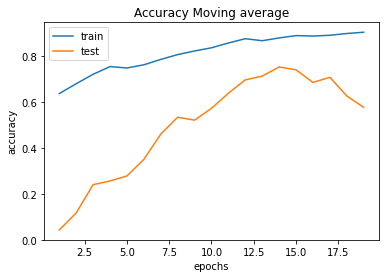

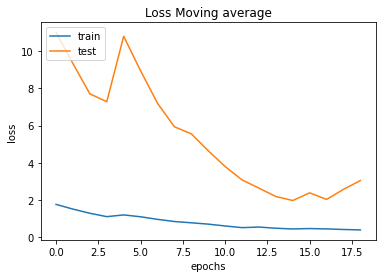

In [52]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history_train = smooth_curve(resnet.history['accuracy'])
smooth_mae_history_val = smooth_curve(resnet.history['val_accuracy'])
plt.plot(range(1, len(smooth_mae_history_train) + 1), smooth_mae_history_train)
plt.plot(range(1, len(smooth_mae_history_val) + 1), smooth_mae_history_val)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Moving average')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(smooth_curve(resnet.history['loss']))
plt.plot(smooth_curve(resnet.history['val_loss']))
plt.title('Loss Moving average')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

망한결과(레이어 다 freeze했을때)

In [ ]:
# Fits the model on batches with real-time data augmentation
dense = model.fit(train_generator,
                            epochs=50,
                            validation_data=validation_generator,
                            callbacks=my_callbacks)

Epoch 1/50
1131/1131 [==============================] - 17762s 16s/step - loss: 2.7314 - accuracy: 0.2804 - val_loss: 3.6259 - val_accuracy: 0.1341

Epoch 00001: val_loss improved from inf to 3.62593, saving model to /content/gdrive/My Drive/01-3.6259.hdf5
Epoch 2/50
1131/1131 [==============================] - 143s 126ms/step - loss: 1.6523 - accuracy: 0.5192 - val_loss: 3.7207 - val_accuracy: 0.0477

Epoch 00002: val_loss did not improve from 3.62593
Epoch 3/50
1131/1131 [==============================] - 134s 119ms/step - loss: 1.3957 - accuracy: 0.5835 - val_loss: 4.1505 - val_accuracy: 0.0477

Epoch 00003: val_loss did not improve from 3.62593
Epoch 4/50
1131/1131 [==============================] - 134s 118ms/step - loss: 1.2832 - accuracy: 0.6115 - val_loss: 3.5797 - val_accuracy: 0.0477

Epoch 00004: val_loss improved from 3.62593 to 3.57974, saving model to /content/gdrive/My Drive/04-3.5797.hdf5
Epoch 5/50
1131/1131 [==============================] - 132s 117ms/step - loss: 1.